In [1]:
import planetary_computer
from pystac_client import Client
import stackstac
import xarray as xr
import rioxarray as rio
import numpy as np
import pandas as pd
import geopandas as gpd
import os

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray as rio
from rasterio.features import rasterize
from rasterio.enums import Resampling

from shapely import Point
from shapely.geometry import shape, box
import math as math
import calendar

import pandas as pd
from pathlib import Path
import folium
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import gc

root = Path.cwd()

In [2]:
from osgeo import gdal
# GDAL configurations
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
#gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')
gdal.SetConfigOption('GDAL_HTTP_MAX_RETRY', '10')
gdal.SetConfigOption('GDAL_HTTP_RETRY_DELAY', '0.5')

gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','.tif, .tiff')

In [ ]:
from dask.distributed import Client as da_client
from dask.distributed import LocalCluster

cluster = LocalCluster(
    n_workers=2,              
    threads_per_worker=1,     
    memory_limit='16GB',       
)
dask_client = da_client(cluster)
dask_client

In [33]:
def map_sentinel_tiles(boundary):
    s2_grid_url = "https://unpkg.com/sentinel-2-grid/data/grid.json"
    grid_gdf = gpd.read_file(s2_grid_url)

    # find tiles that intersect with AOI
    bb = boundary.boundary.to_crs(grid_gdf.crs)
    tiles = grid_gdf[grid_gdf.intersects(bb.geometry.iloc[0])]
    exploded = tiles.explode()[0:] # separate geometry collection into single geometries

    m = folium.Map(location=(42.44,-76.21), zoom_start=5, tiles='OpenStreetMap')

    folium.GeoJson(
        exploded,
        tooltip=folium.GeoJsonTooltip(fields=["id"])
    ).add_to(m)

    folium.GeoJson(bb).add_to(m)
    
    return m

def get_sentinel_tiles(boundary):
    """Get tile ids that overlap boundary"""
    
    s2_grid_url = "https://unpkg.com/sentinel-2-grid/data/grid.json"
    grid_gdf = gpd.read_file(s2_grid_url)

    # find tiles that intersect with AOI
    bb = boundary.boundary.to_crs(grid_gdf.crs)
    tiles = grid_gdf[grid_gdf.intersects(bb.geometry.iloc[0])]
    
    return [t for t in tiles['name']]



def remove_outliers(a,min,max):  # slavi: 0-20, psri: -0.5 - 1.0
    #a = a.where(np.isfinite(a),np.nan)
        a = xr.where(np.isfinite(a),a,np.nan)
        a = a.clip(min=min,max=max)
        return a

def get_variables(data):
        blue = data.sel(band='B02')
        red = data.sel(band='B04')
        nir = data.sel(band='B8A')
        sw1 = data.sel(band='B11')
        sw2 = data.sel(band='B12')
        re2 = data.sel(band='B06')


        evi = 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1)).expand_dims({'band':['evi']}) 
        lswi = (nir - sw1)/(nir + sw1).expand_dims({'band':['lswi']}) 
        slavi = nir/(red + sw2).expand_dims({'band':['slavi']}) 
        psri = (red - blue)/re2.expand_dims({'band':['psri']}) 

        # bright = (0.3510*blue)+(0.3813*green)+(0.3437*red)+(0.7196*nir)+(0.2396*sw1)+(0.1949*sw2).expand_dims({'band':[f'bright_{season_list[i]}']})
        # bright = self.remove_outliers(bright)

        # wet = (0.2578*blue)+(0.2305*green)+(0.0883*red)+(0.1071*nir)+(-0.7611*sw1)+(-0.5308*sw2).expand_dims({'band':[f'wet_{season_list[i]}']})
        # wet = self.remove_outliers(wet)

        # green = (-0.3599*blue)+(-0.3533*green)+(-0.4734*red)+(0.6633*nir)+(0.0087*sw1)+(-0.2856*sw2).expand_dims({'band':[f'green_{season_list[i]}']})
        # green = self.remove_outliers(green)

        evi = remove_outliers(evi,min=-1,max=1)
        lswi = remove_outliers(lswi,min=-1,max=1)
        slavi = remove_outliers(slavi,min=0,max=20)
        psri = remove_outliers(psri,min=-0.5,max=1.0)

        all_vars = xr.concat([data,evi,lswi,slavi,psri],dim='band')
        # ## mask non-forest pixels
        # self.all_variables = m3.where(m3.sel(band=f'evi_month{num_of_peak_evi_month}')>0.5,other=np.nan)
        #all_vars = xr.where(all_vars.isel(time=1,band=0)>=0.5,all_vars,np.nan)

        return all_vars




def get_gradient(im) :
        # Calculate the x and y gradients using Sobel operator
        grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
        grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
        # Combine the two gradients
        grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)

        return grad
    

def coregister_data(data):
    # open raw sentinel data file
    #data = xr.open_dataarray(self.root / 'sentinel_data' / self.site_name / f'{self.year}_{self.site_name}.nc')

    data = data.astype('float32') # convert from float64 to save memory
    # set nans to 0
    b_sel = xr.where(~np.isnan(data), data, 0)

    # create reference image: median nir band of all temporal steps
    reference_image = data.isel(band=6).median(dim='time',skipna=True)
    # replace na with 0 
    reference_image = xr.where(~np.isnan(reference_image),reference_image,0)
    # convert to numpy array
    reference_image = reference_image.to_numpy()

    # define dimensions for output image
    height = b_sel.shape[2]
    width = b_sel.shape[3]
    time = b_sel.shape[0]
    band = b_sel.shape[1]

    ## Define motion model
    #warp_mode = cv2.MOTION_AFFINE
    warp_mode = cv2.MOTION_TRANSLATION

    # Set the stopping criteria for the algorithm.
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)

    # Create empty array of correct size for new aligned images
    im_aligned = np.zeros((time,band,height,width), dtype=np.float32 )
    s = np.zeros(time, dtype=bool) # store indexes of successful alignments

    ref_image_gradient = get_gradient(reference_image)

    #im = b_sel.to_numpy()
    # loop over time and band dimensions and apply coregistration to each band
    # calculate warp_matrix for only one band per timestamp and apply to all bands
    
    for i in tqdm(range(0,time)):
        im = b_sel.isel(time=i).to_numpy()  # shape: (band, y, x)
        # get just nir band for calculating warp matrix
        red_band = im[6,:,:]
        red_gradient = get_gradient(red_band)

        
        # set identity warp matrix
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        # calculate warp matrix based on red band and reference image
        try:
            (_, warp_matrix) = cv2.findTransformECC(ref_image_gradient, red_gradient, warp_matrix, warp_mode, criteria) 
        except cv2.error as e:
            im_aligned[i,:,:,:] = np.full((band,height,width),np.nan)
            print(f'failed to converge - skipping timestep {i}')
            continue
        
        # apply transformation to each band 
        for j in range(0,band):                                
            im_aligned[i,j,:,:] = cv2.warpAffine(im[j,:,:], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        s[i] = True
        del im
        gc.collect() # free memory
    
    # retain only timesteps for which alignment was successful
    b_align = xr.DataArray(im_aligned[s,:,:,:], 
                    coords={'time':b_sel.time.values[s],'band': b_sel.band,'y': b_sel.y,'x':b_sel.x}, 
                    dims=['time','band','y','x'])
    # reset 0 values to na
    b_align = xr.where(b_align == 0, np.nan, b_align)

    return b_align



def build_summer_timeseries(boundary, years, tiles, cf_mosaic=True):
    """Downloads Sentinel-2 data between June 15th - August 15th for each year, mosaics adjacent/overlapping tiles, masks cloud/shadows/water/snow/aerosol, applies scale factor (and offset if processing baseline < 4.0), co-registers images, calculates vegetation indices, and assembles into timeseries. 

    If cf_mosaic = False, takes the single least cloudy image per year.
    If cf_mosaic = True, creates median mosaic of all available images per year."""

    epsg = boundary.crs.to_epsg()
    bbox_4326 = tuple(boundary.to_crs(4326).total_bounds)
    bbox_utm = tuple(boundary.total_bounds)

    catalog = Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )


    query = {"eo:cloud_cover":{"lt":20},
            "s2:mgrs_tile": {'in':tiles}} 

    timesteps = []

    for year in years:
        items = catalog.search(
            bbox=bbox_4326,
            collections=["sentinel-2-l2a"],
            datetime=f"{year}-06-15/{year}-08-15",
            query= query #"s2:mgrs_tile": {"eq": tile_id},
        ).item_collection()
        print(f'{year}: number of images found: {len(items)}')
        if len(items) == 0:
            print(f'SKIPPING {year}')
            continue
        
        # get images with highest (i.e. most recent) processing baseline.
        # if highest baseline is less than 4.0, set apply offset to true. 
        baselines = []
        for i in items:
            baselines.append(float(i.properties.get('s2:processing_baseline')))
        highest = np.max(baselines)
        selected_items = [i for i in items if float(i.properties.get('s2:processing_baseline')) == highest]
        if highest < 4.0:
            apply_offset = True
            print(f'processing baseline: {highest} - applying offset')
        else:
            apply_offset = False
            print(f'processing baseline: {highest}')
        
        # create xarray
        stack = stackstac.stack(
            selected_items,
            epsg=epsg,
            resolution=10,
            bounds=bbox_utm,
            assets=['B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12','SCL'],
            resampling=Resampling.bilinear)


        #stack = stack.chunk({'time':timechunk,'band':bandchunk,'y':None,'x':None})

        # # # crop to boundary
        stack = stack.rio.clip(geometries=boundary.geometry)

        stack  = stack.assign_coords(time=stack['time'].dt.floor('D'))

        mosaic = stack.groupby('time').median(dim='time',skipna=True) # merge images from different tiles taken on same day

        mosaic = mosaic.drop_attrs()
        mosaic = mosaic.reset_coords(drop=True)

        #mosaic = mosaic.chunk({'time':None,'band':None,'y':1024,'x':1024})

        mosaic = mosaic.astype('float32')

        scl = mosaic.sel(band='SCL')
        mask = ~scl.isin([1, 3, 6, 8, 9, 10, 11])
        #mask = ~scl.isin([1, 3, 6, 8, 9, 10, 11]).persist()

        masked = mosaic.where(mask).drop_sel(band='SCL')

        if apply_offset:
                scaled = (masked + 1000)/ 10000
        else:
                scaled = masked / 10000
        
        scaled = scaled.clip(min=0) # set minimum reflectance to 0

        #masked = masked.where(masked > 0, other=np.nan)
        # get single least cloudy image
        if not cf_mosaic:
            sample_band = scaled.isel(band=0)  
            #valid_pixel_count = da.sum(da.isfinite(sample_band.data), axis=(1, 2))
            valid_pixel_count = sample_band.count(dim=['y','x']).values
            v = valid_pixel_count.argmax() # index of timestep with most valid pixels
            scaled_lc = scaled.isel(time=v)
            timesteps.append(scaled_lc)
        else:
            timesteps.append(scaled)

    ts = xr.concat(timesteps,dim='time')

    # align
    # print('aligning bands')
    # aligned = coregister_data(ts)
    with_indices = get_variables(ts)

    if cf_mosaic:  # create median mosaic of all available timesteps per year
        aggregated = with_indices.groupby('time.year').median(dim='time', skipna=True) 
        return aggregated
    else:
        return with_indices

 
def get_medoid_composite(group):
    a = group.transpose('time', 'band', 'y', 'x')
    median = a.median(dim='time')

    dist = np.sqrt(((a-median)**2).sum(dim='band',skipna=True))
    
    valid_mask = np.isfinite(dist).any(dim='time') # preserve where nans are
    idx = dist.fillna(np.inf).argmin(dim='time').compute()   # for each pixel, get time with minimum distance value
    
    out = a.isel(time=idx)

    return out.where(valid_mask) # replace nans



In [40]:
def build_monthly_timeseries(boundary, year, medoid=True):

    epsg = boundary.crs.to_epsg()
    bbox_4326 = tuple(boundary.to_crs(4326).total_bounds)
    bbox_utm = tuple(boundary.total_bounds)
    # make a square polygon for clipping AOI
    boundary_polygon = gpd.GeoDataFrame(geometry=[box(*bbox_utm)], crs=f"EPSG:{epsg}")

    catalog = Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )

    query = {"eo:cloud_cover":{"lt":20}} 

    items = catalog.search(
        bbox=bbox_4326,
        collections=["sentinel-2-l2a"],
        datetime=f"{year}-01-01/{year}-12-31",
        query= query 
    ).item_collection()
    print(f'{year}: number of images found: {len(items)}')

    # put details into a dataframe
    records = []
    for i in items:
        records.append({
            'id': i.id,
            'datetime': i.datetime,
            'tile' : i.properties.get('s2:mgrs_tile'),
            'baseline': float(i.properties.get('s2:processing_baseline'))
        })

    df = pd.DataFrame(records)
    df['datetime'] = df['datetime'].dt.floor('D')

    # if two versions of image exist, select the one with the higher processing baseline
    selected_records = df.sort_values('baseline', ascending=False).drop_duplicates(['datetime','tile'], keep='first')
    selected_ids = set(selected_records['id'])
    selected_items = [i for i in items if i.id in selected_ids]
    ### save the datetimes for images with baseline less than 4 for applyng offset later
    below_4_dates = selected_records.loc[selected_records['baseline']<4.0,'datetime'] 
    print(below_4_dates)

    #create xarray
    stack = stackstac.stack(
        selected_items,
        epsg=epsg,
        resolution=10,
        bounds=bbox_utm,
        assets=['B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12','SCL'],
        resampling=Resampling.bilinear)


    #stack = stack.chunk({'time':timechunk,'band':bandchunk,'y':None,'x':None})

    # # # crop to boundary
    stack = stack.rio.clip(geometries=boundary_polygon.geometry)

    stack  = stack.assign_coords(time=stack['time'].dt.floor('D')) # convert timestamp to just the day

    if len(df['tile'].unique()) > 1:
        mosaic = stack.groupby('time').max(dim='time',skipna=True)  # merge images from different tiles taken on same day
        mosaic = mosaic.drop_attrs().reset_coords(drop=True).astype('float32')
    else:
        mosaic = stack.drop_attrs().reset_coords(drop=True).astype('float32')


    #mosaic = mosaic.chunk({'time':None,'band':None,'y':1024,'x':1024})

    scl = mosaic.sel(band='SCL')
    mask = ~scl.isin([1, 3, 6, 8, 9, 10, 11])
    #mask = ~scl.isin([1, 3, 6, 8, 9, 10, 11]).persist()

    masked = mosaic.where(mask).drop_sel(band='SCL') # apply quality mask and drop scl band

    # offset (if baseline < 4) and scale
    offset_mask = masked.time.isin(pd.to_datetime(below_4_dates)).astype('float32')

    scaled = (masked + offset_mask * 1000) / 10000  

    scaled = scaled.clip(min=0) # set minimum reflectance to 0

    # co-register
    aligned = coregister_data(scaled)
    #aligned = scaled

    
    if medoid: # get medoid composite for each month
        month_groups = aligned.groupby('time.month')
        ts = month_groups.map(get_medoid_composite)
        ts = ts.assign_coords({'month':[f'{calendar.month_abbr[m]}-{year}' for m in ts['month'].values]})
    else: # get single least cloudy image per month
        sample_band = aligned.isel(band=0)
        valid_pixel_count = sample_band.count(dim=['y','x'])

        least_cloudy_times = valid_pixel_count.groupby('time.month').map(lambda m: m.idxmax(dim='time')) # return coord of maximum
        ts = scaled.sel(time=least_cloudy_times.values)
        ts = ts.assign_coords({'time':[pd.Timestamp(m).strftime('%b-%d-%y') for m in ts['time'].values]})
        

    return ts


In [ ]:

boundary = gpd.read_file(root / 'data' / 'harvard' / 'all_beech_polys_health.gpkg')

year = 2025

ts = build_monthly_timeseries(boundary=boundary, year=year, medoid=False)

# time series of least cloudy image per month; all aligned to median image. 
# years internally aligned, but not aligned across years. 

2025: number of images found: 19
Series([], Name: datetime, dtype: datetime64[ns, tzutc()])


100%|██████████| 19/19 [00:33<00:00,  1.78s/it]


In [51]:
ts.to_netcdf(root / 'data' / 'harvard' / f'{year}_harvard_monthly_lowcloud_timeseries_bands.nc')

In [97]:
from shapely.geometry import Point

def convert_coords(d,m,s):
    return d + (m / 60) + (s / 3600)


d, m, s = -74, 0, 58.26169
lon = convert_coords(d,m,s)

d, m, s = 41, 24, 27.18393
lat = convert_coords(d,m,s)

p1 = Point(lon,lat)


gdf = gpd.GeoDataFrame({'location': 'BRF'},index=[0],geometry=[p1],crs=4326)


In [101]:
gdf.to_file(root / 'data' / 'brf.gpkg')

In [50]:
gdf = gdf.to_crs('EPSG:26918')

# add 100 m buffer

gdf['buffer'] = gdf.buffer(distance=100,cap_style='square')

gdf = gdf.rename(columns={'geometry':'point','buffer':'geometry'}).set_geometry('geometry')

In [51]:
tiles = get_sentinel_tiles(gdf)

In [52]:
brf_ts = build_summer_timeseries(boundary=gdf,years=[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],tiles=tiles,cf_mosaic=False)

2016: number of images found: 6
processing baseline: 3.0 - applying offset
2017: number of images found: 4
processing baseline: 2.12 - applying offset
2018: number of images found: 7
processing baseline: 2.12 - applying offset
2019: number of images found: 9
processing baseline: 2.12 - applying offset
2020: number of images found: 12
processing baseline: 2.12 - applying offset
2021: number of images found: 6
processing baseline: 3.0 - applying offset
2022: number of images found: 7
processing baseline: 4.0
2023: number of images found: 6
processing baseline: 5.1
2024: number of images found: 4
processing baseline: 5.11
2025: number of images found: 9
processing baseline: 5.11


In [53]:
brf_ts.to_netcdf(root / 'data' / 'brf_all.nc')

In [123]:
brf_evi = brf_ts.sel(band='evi')
brf_evi.to_netcdf(root / 'data' / 'brf_evi_nonmosaic.nc')

In [56]:
brf = xr.open_dataarray(root / 'data' / 'brf_all.nc')

vis = brf.band.values[10:]

vis

array(['evi', 'lswi', 'slavi', 'psri'], dtype='<U5')

In [66]:
mean_dict = {}
sd_dict = {}

for v in vis:
    vi = brf.sel(band=v)

    end_less = xr.where(vi.isel(time=-1)<vi.isel(time=0),vi,np.nan)

    end_less_2d = end_less.stack(pixel=('y','x')).transpose('pixel','time').to_pandas()
    e = end_less_2d.dropna().reset_index()

    e = e.drop(e.columns[5],axis=1)
    mean = e.iloc[2:,2:].T.mean(axis=1)
    sd = e.iloc[2:,2:].T.std(axis=1)

    mean_dict[v] = mean
    sd_dict[v] = sd

In [69]:
mean_dict['slavi']

time
2016-07-27 00:00:00    1.387732
2017-07-02 00:00:00    1.353593
2018-06-17 00:00:00    1.429682
2020-06-26 00:00:00    1.374972
2021-06-24 00:00:00    1.534256
2022-06-19 00:00:00    1.583175
2023-07-11 00:00:00    1.212193
2024-08-14 00:00:00    1.212842
2025-06-25 00:00:00    1.321493
dtype: float32

In [68]:
mean_dict['evi']

time
2016-07-27 00:00:00    0.651063
2017-07-02 00:00:00    0.627771
2018-06-17 00:00:00    0.649160
2020-06-26 00:00:00    0.709538
2021-06-24 00:00:00    0.676361
2022-06-19 00:00:00    0.685979
2023-07-11 00:00:00    0.600465
2024-08-14 00:00:00    0.544607
2025-06-25 00:00:00    0.636547
dtype: float32

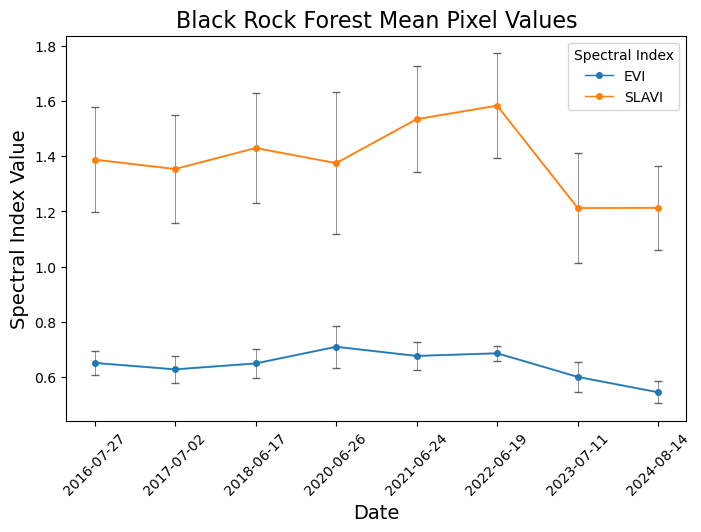

In [94]:
plt.figure(figsize=(8, 5))
colors = plt.cm.tab10.colors
for i, index_name in enumerate(['evi','slavi']):
    row = mean_dict[index_name]
    sd = sd_dict[index_name].values[:-1]

    years = [r.strftime('%Y-%m-%d') for r in row.index][:-1]
    #years = row.index
    values = row.values[:-1]
    color = colors[i]


    plt.errorbar(years, values, yerr=sd, color=color,ecolor='black',capsize=3,elinewidth=.5,alpha=0.6)
    plt.plot(years, values, marker='o',color=color,markersize=4,linewidth=1,label=index_name.upper())
    
plt.xlabel('Date',fontsize=14)
plt.ylabel('Spectral Index Value',fontsize=14)
plt.xticks(rotation=45)
#plt.ylim(0.4,1)
plt.title('Black Rock Forest Mean Pixel Values',fontsize=16)
plt.legend(title='Spectral Index')
plt.show()

In [115]:
#brf_evi = brf_evi.rename({'year':'time'})
#brf_evi = xr.open_dataarray(root / 'data' / 'brf_evi_nonmosaic.nc')

vi = brf.sel(band='slavi')
end_less = xr.where(vi.isel(time=-1)<vi.isel(time=0),vi,np.nan)

end_less_2d = end_less.stack(pixel=('y','x')).transpose('pixel','time').to_pandas()
e = end_less_2d.dropna().reset_index()

In [ ]:
e = e.drop(e.columns[5],axis=1)

time
2016-07-27 00:00:00    1.387732
2017-07-02 00:00:00    1.353593
2018-06-17 00:00:00    1.429682
dtype: float32

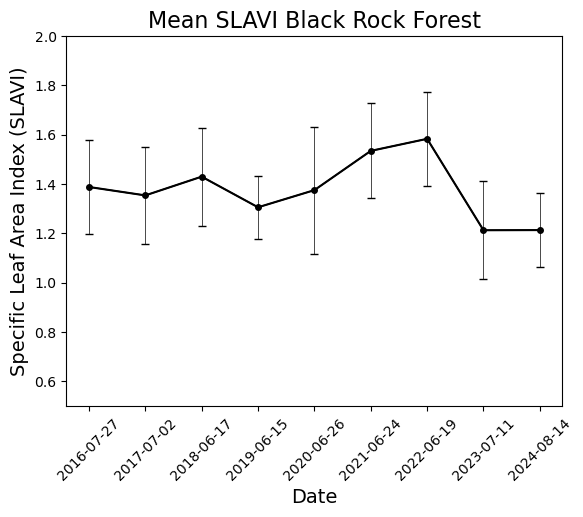

In [118]:

mean = e.iloc[2:,2:-1].T.mean(axis=1)
sd = e.iloc[2:,2:-1].T.std(axis=1)

row = mean
years = [r.strftime('%Y-%m-%d') for r in row.index]
#years = row.index
values = row.values

plt.errorbar(years, values, yerr=sd, color='black',ecolor='black',capsize=3,elinewidth=.5)
plt.plot(years, values, marker='o',color='black',markersize=4,linewidth=1)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Specific Leaf Area Index (SLAVI)',fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0.5,2)
plt.title('Mean SLAVI Black Rock Forest',fontsize=16)
plt.show()

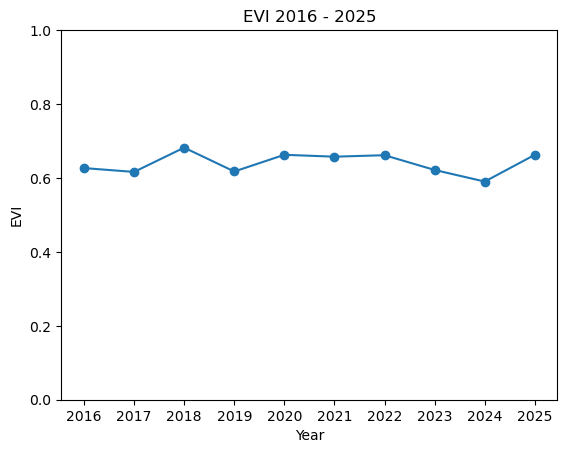

In [36]:
brf_evi = xr.open_dataarray(root / 'data' / 'brf_evi.nc')

# plot random pixel
# y_coord = np.nanmedian(brf_evi.y.values)
# x_coord = np.nanmedian(brf_evi.x.values)

y_coord = 4250000.0
x_coord =  584960.0

pixel_ts = brf_evi.sel(x=x_coord,y=y_coord,method='nearest')


fig, ax = plt.subplots()
pixel_ts.plot(ax=ax, marker='o')
ax.set_xticks(pixel_ts.year.values)
ax.set_ylabel('EVI')
ax.set_xlabel('Year')
ax.set_ylim((0,1))
ax.set_title('EVI 2016 - 2025')

plt.show()

In [5]:
def build_daily_sentinel_timeseries(boundary, years, tiles):
    """Downloads Sentinel-2 data between each year, mosaics adjacent/overlapping tiles, masks cloud/shadows/water/snow/aerosol, applies scale factor (and offset if processing baseline < 4.0), co-registers images, calculates vegetation indices, and assembles into timeseries. 

    If cf_mosaic = False, takes the single least cloudy image per year.
    If cf_mosaic = True, creates median mosaic of all available images per year."""

    epsg = boundary.crs.to_epsg()
    bbox_4326 = tuple(boundary.to_crs(4326).total_bounds)
    bbox_utm = tuple(boundary.total_bounds)

    catalog = Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )


    query = {"eo:cloud_cover":{"lt":20},
            "s2:mgrs_tile": {'in':tiles}} 

    #timesteps = []

    for year in years:
        items = catalog.search(
            bbox=bbox_4326,
            collections=["sentinel-2-l2a"],
            datetime=f"{year}-01-01/{year}-12-31",
            query= query #"s2:mgrs_tile": {"eq": tile_id},
        ).item_collection()
        print(f'{year}: number of images found: {len(items)}')
        if len(items) == 0:
            print(f'SKIPPING {year}')
            continue
        
        # get images with highest (i.e. most recent) processing baseline.
        # if highest baseline is less than 4.0, set apply offset to true. 
        baselines = []
        for i in items:
            baselines.append(float(i.properties.get('s2:processing_baseline')))
        highest = np.max(baselines)
        selected_items = [i for i in items if float(i.properties.get('s2:processing_baseline')) == highest]
        if highest < 4.0:
            apply_offset = True
            print(f'processing baseline: {highest} - applying offset')
        else:
            apply_offset = False
            print(f'processing baseline: {highest}')
        
        # create xarray
        stack = stackstac.stack(
            selected_items,
            epsg=epsg,
            resolution=10,
            bounds=bbox_utm,
            assets=['B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12','SCL'],
            resampling=Resampling.bilinear)


        stack = stack.chunk({'time':-1,'band':-1,'y':'auto','x':'auto'})

        # # # crop to boundary
        stack = stack.rio.clip(geometries=boundary.geometry)

        stack  = stack.assign_coords(time=stack['time'].dt.floor('D'))

        mosaic = stack.groupby('time').median(dim='time',skipna=True) # merge images from different tiles taken on same day

        mosaic = mosaic.drop_attrs()
        mosaic = mosaic.reset_coords(drop=True)

        mosaic = mosaic.chunk({'time':'auto','band':-1,'y':1024,'x':1024})

        mosaic = mosaic.astype('float32')

        scl = mosaic.sel(band='SCL')
        mask = ~scl.isin([1, 3, 6, 8, 9, 10, 11])
        #mask = ~scl.isin([1, 3, 6, 8, 9, 10, 11]).persist()

        masked = mosaic.where(mask).drop_sel(band='SCL')

        if apply_offset:
                scaled = (masked + 1000)/ 10000
        else:
                scaled = masked / 10000
        
        scaled = scaled.clip(min=0) # set minimum reflectance to 0

      

        #masked = masked.where(masked > 0, other=np.nan)
        # get single least cloudy image
        scaled.to_zarr(root / 'data' / f'ordway_evi_daily_{year}.zarr')
   
    #     timesteps.append(scaled)

    # ts = xr.concat(timesteps,dim='time')

    # # align
    # # print('aligning bands')
    # # aligned = coregister_data(ts)
    # with_indices = get_variables(ts)

  
    # return with_indices

In [ ]:
# version 1: take the single least cloudy image per year
# version 2: create median mosaic of all images available per year

In [ ]:
b = gpd.read_file(root / 'data' / 'ordway' / 'ordway_boundary.gpkg')
boundary = b.to_crs(epsg=26917)

tiles = get_sentinel_tiles(boundary)

build_daily_sentinel_timeseries(boundary=boundary,years=[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],tiles=tiles )

In [ ]:
b = gpd.read_file(root / 'data' / 'ordway' / 'ordway_boundary.gpkg')
boundary = b.to_crs(epsg=26917)

tiles = get_sentinel_tiles(boundary)

tsv2 = build_summer_timeseries(boundary,years=[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025], tiles=tiles,cf_mosaic=True)


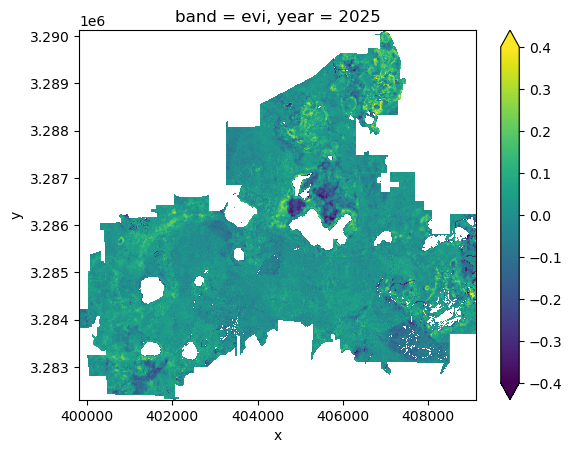

In [ ]:
# plot 9-year anomaly 

m = xr.open_dataarray(root / 'data' / 'ordway' / 'summer_ts_mosaiced.nc')
evi_ts = m.sel(band='evi')

veg_mask = xr.where(evi_ts>=0.2,evi_ts,np.nan)

med_evi = veg_mask.isel(year=slice(0,-1)).median(dim='year')
evi_2025 = veg_mask.isel(year=-1)

anom = evi_2025 - med_evi

anom.plot(vmin=-0.4,vmax=0.4)

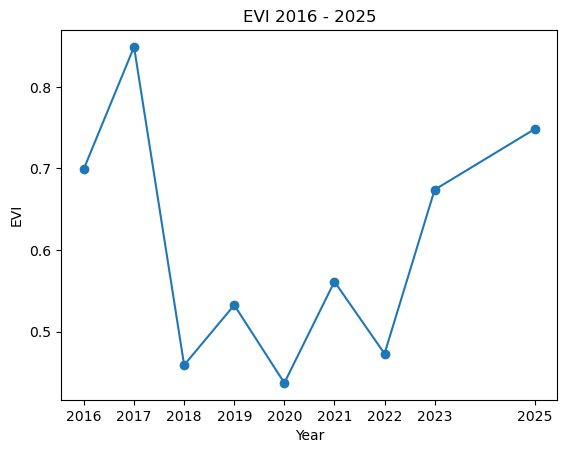

In [ ]:
# plot random pixel
y_coord = np.nanmedian(anom.y.values)
x_coord = np.nanmedian(anom.x.values)

pixel_ts = evi_ts.sel(x=x_coord,y=y_coord,method='nearest')


fig, ax = plt.subplots()
pixel_ts.plot(ax=ax, marker='o')
ax.set_xticks(pixel_ts.year.values)
ax.set_ylabel('EVI')
ax.set_xlabel('Year')
ax.set_title('EVI 2016 - 2025')

plt.show()